In [1]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image


import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from keras import layers, optimizers, losses, metrics


import sklearn
from keras import utils
from sklearn.preprocessing import LabelEncoder

In [2]:
# dir_path points towards where to find the image dataset
dir_path_train = "data/training_set/training_set"
dir_path_test = "data/test_set/test_set"
IMAGE_SHAPE = (224, 224)

# This is a good sample as it gives a good mix of val data
random_sample = 1

In [3]:
# Read the folders folders
directories_train, directories_test = os.listdir(dir_path_train), os.listdir(dir_path_train)

files_train, files_test = [], []
labels_train, labels_test = [], []

for folder in directories_train:
    
    fileList = glob.glob(f'{dir_path_train}/{folder}/*')
    labels_train.extend([folder for _ in fileList])
    files_train.extend(fileList)

for folder in directories_test:
    
    fileList = glob.glob(f'{dir_path_test}/{folder}/*')
    labels_test.extend([folder for _ in fileList])
    files_test.extend(fileList)

len(files_train), len(labels_train), len(files_test), len(labels_test)

(8005, 8005, 2023, 2023)

In [4]:
# Count the number of labels to get an idea of how balanced the dataset is
unique, counts = np.unique(labels_train, return_counts=True)
print(dict(zip(unique, counts)))

{'cats': 4000, 'dogs': 4005}


In [5]:
# One hot encoding for train

# Encode class values as integers
encoder_train, encoder_test = LabelEncoder(), LabelEncoder()
encoder_train.fit(labels_train)
encoder_test.fit(labels_test)
encoded_Y_train = encoder_train.transform(labels_train)
encoded_Y_test  = encoder_test.transform(labels_test)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = utils.to_categorical(encoded_Y_train,dtype ="uint8", num_classes = 2)
dummy_y_test = utils.to_categorical(encoded_Y_test,dtype ="uint8", num_classes = 2)

labels_train = np.array(dummy_y_train)
labels_test = np.array(dummy_y_test)

print(f"Classes are {encoder_train.classes_}")

Classes are ['cats' 'dogs']


In [6]:
images_train, images_test = [], []

for path in files_train:
    img_arr = cv2.imread(path)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    resized_arr = cv2.resize(img_arr, (256, 256)) # Reshaping images to preferred size
    images_train.append(resized_arr)

for path in files_test:
    img_arr = cv2.imread(path)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    resized_arr = cv2.resize(img_arr, (256, 256)) # Reshaping images to preferred size
    images_test.append(resized_arr)
    

In [7]:
x_train, x_val, y_train, y_val = train_test_split(images_train, labels_train, test_size=.1, random_state = random_sample)
x_test_A, x_test_B, y_test_A, y_test_B = train_test_split(images_test, labels_test, test_size = .2, random_state=random_sample)

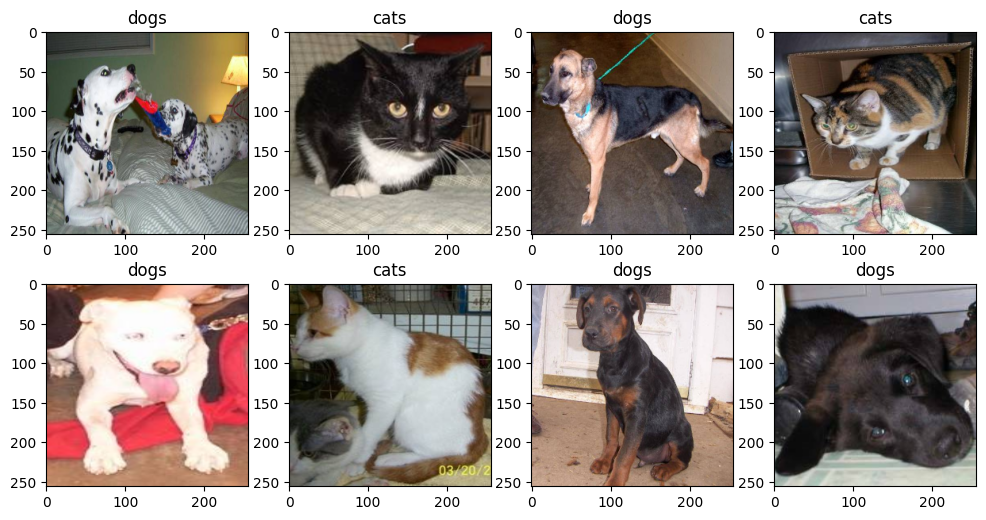

In [8]:
fig, axs = plt.subplots(2,4, figsize = (12,6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(x_test_A[i])
    ax.set_title(encoder_train.classes_[y_test_A[i][1]])

In [9]:
def get_label_counts(y_train,
                     y_val,
                     y_test_A,
                     y_test_B,
                     class_names = ["0","1"]):
    
    for dataset, dataset_name in zip([y_train,y_val,y_test_A,y_test_B],["Train","Val","Test A","Test B"]):
        
        unique_rows, count = np.unique(dataset, axis=0,return_counts=True)
        out = {tuple(i):j for i,j in zip(unique_rows,count)}
        print(f"\n{dataset_name}\n{out}  {class_names}")

In [10]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = encoder_train.classes_)


Train
{(0, 1): 3598, (1, 0): 3606}  ['cats' 'dogs']

Val
{(0, 1): 407, (1, 0): 394}  ['cats' 'dogs']

Test A
{(0, 1): 805, (1, 0): 813}  ['cats' 'dogs']

Test B
{(0, 1): 207, (1, 0): 198}  ['cats' 'dogs']


In [11]:
x_train  = np.array(x_train)
x_val    = np.array(x_val)
x_test_A = np.array(x_test_A)
x_test_B = np.array(x_test_B)
x_test   = np.array(images_test)

y_train   = np.array(y_train)
y_val     = np.array(y_val)
y_test_A  = np.array(y_test_A)
y_test_B  = np.array(y_test_B)
y_test    = np.array(labels_test)

In [12]:
x_train.shape

(7204, 256, 256, 3)

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [14]:
from tensorflow.keras.applications import EfficientNetV2S
base_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=((256, 256, 3)),
    classes=2,)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(2, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.categorical_crossentropy, metrics= [metrics.CategoricalAccuracy()])


In [15]:
best_model = keras.callbacks.ModelCheckpoint(filepath='./models/best_model_epoch_{epoch:02d}.h5', save_best_only=False)

In [16]:
history = incept_model.fit(datagen.flow(x_train,y_train, batch_size = 32), batch_size = 32, epochs = 3 , validation_data = (x_val, y_val), callbacks=[best_model])

Epoch 1/3
226/226 [==============================] - ETA: 0s - loss: 0.0601 - categorical_accuracy: 0.9824

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


226/226 [==============================] - 751s 3s/step - loss: 0.0601 - categorical_accuracy: 0.9824 - val_loss: 0.0164 - val_categorical_accuracy: 0.9950
Epoch 2/3
226/226 [==============================] - 915s 4s/step - loss: 0.0338 - categorical_accuracy: 0.9903 - val_loss: 0.0174 - val_categorical_accuracy: 0.9950
Epoch 3/3
226/226 [==============================] - 885s 4s/step - loss: 0.0272 - categorical_accuracy: 0.9933 - val_loss: 0.0277 - val_categorical_accuracy: 0.9913


In [35]:
best_model = keras.models.load_model("models/best_model_epoch_03.h5")

In [18]:
def argmax_array(array):
    return([np.argmax(item) for item in array])

In [39]:
predictions = best_model.predict(x_test)

print(classification_report(argmax_array(y_test), argmax_array(predictions), target_names = encoder_train.classes_))

cm = confusion_matrix(argmax_array(y_test), argmax_array(predictions))


64/64 [==============================] - 232s 4s/step
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1011
        dogs       0.99      0.99      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023



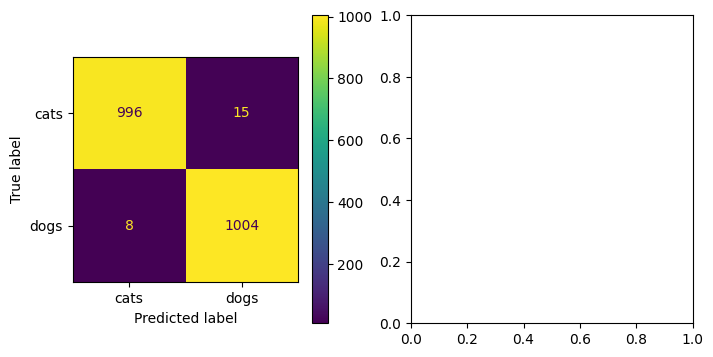

In [40]:
fig, axs = plt.subplots(1,2, figsize = (8,4))

cm_test_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=encoder_train.classes_)

cm_test_display.plot(ax = axs[0])

In [41]:
incorrect_images = []
incorrect_labels = []

for image, label, pred in zip(x_test, y_test, argmax_array(predictions)):
    if np.argmax(label) != pred:
        incorrect_images.append(image)
        incorrect_labels.append(label)

print(len(incorrect_labels))


23


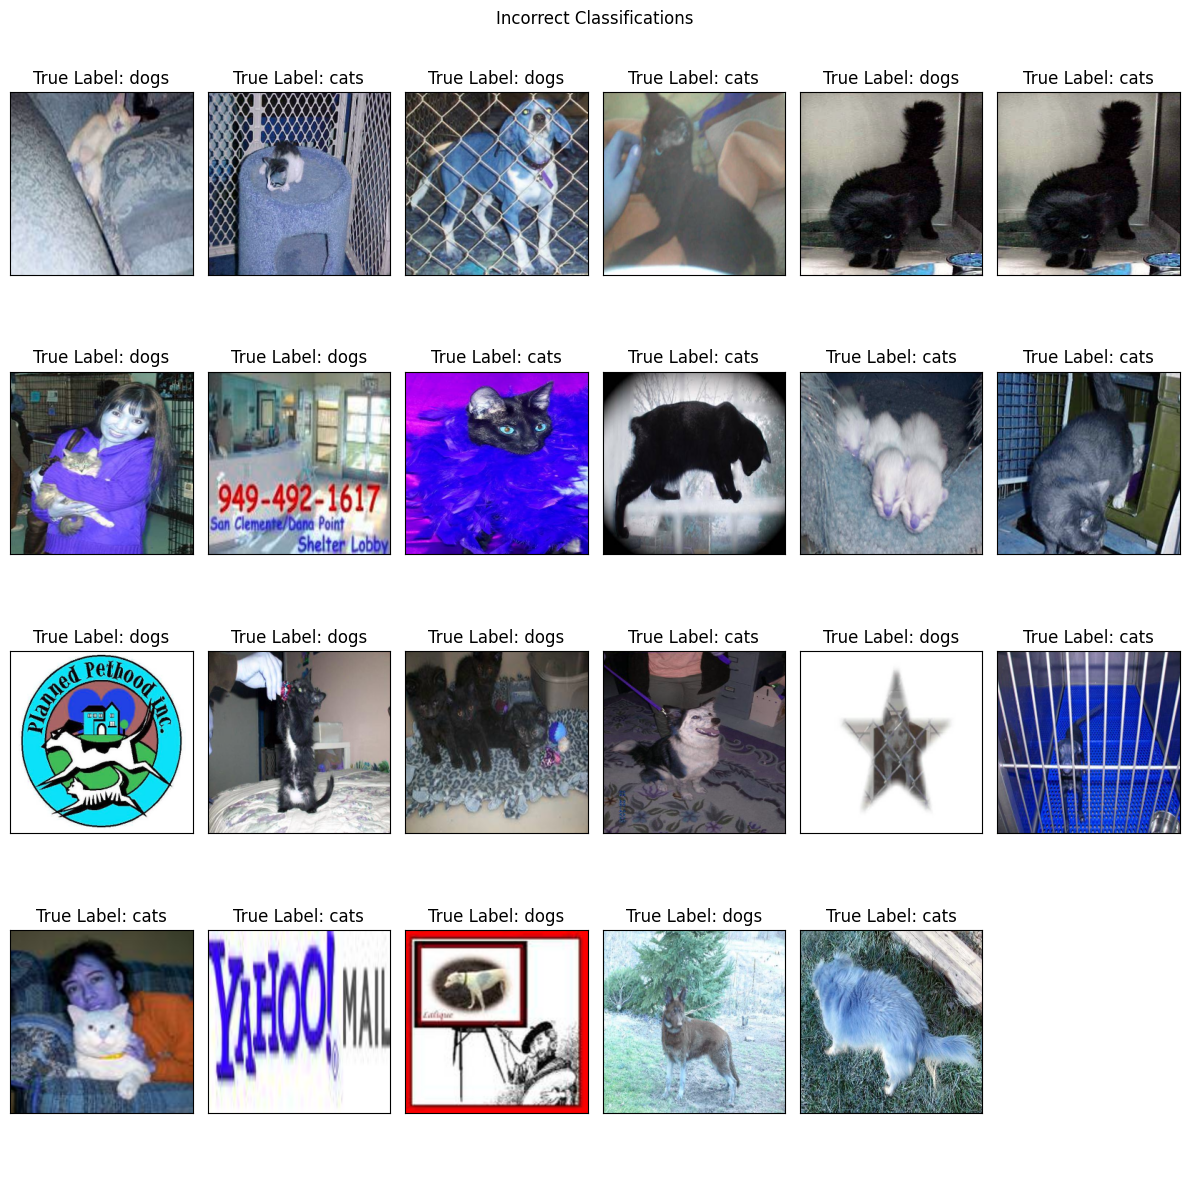

In [59]:
fig, axs = plt.subplots(4,6, figsize = (12,12))



for i, ax in enumerate(axs.flatten()):
    if i < len(incorrect_labels):
        ax.imshow(incorrect_images[i])
        ax.set_title(f"True Label: {encoder_train.classes_[y_test_A[i][1]]}")
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.suptitle("Incorrect Classifications")

plt.axis('off')
plt.tight_layout()